# Scraping and processing rain data
This notebook scraps Meteosuisse rainfall data from a third-party website holding a database. Written by Eliott Guenat in 2020

In [9]:
from lxml import html
import requests
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

from matplotlib import rc
rc('font',**{'family':'serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
plt.rcParams.update({'font.size': 22})

## Scraping the data

In [2]:
df = pd.DataFrame()

In [3]:
DayMth = np.array([[1, 31],[2,28],[3,31],[4,30],[5,31],[6,30],[7,31],[8,31],[9,30],[10,31],[11,30],[12,31]])
Data = np.zeros((1,7300))            

for year in np.arange(2000,2020):
    cnt = 0
    for month in np.arange(1,13):
        StrMth = str(month)
        if month < 10:
            StrMth = '0'+StrMth
    
        for day in np.arange(1,DayMth[month-1,1]+1):
                   StrDay = str(day)
                   if day < 10:
                       StrDay = '0'+StrDay  
                   page = requests.get('https://www.prevision-meteo.ch/climat/horaire/geneve-cointrin/'+str(year)+'-'+StrMth+'-'+StrDay)
                   tree = html.fromstring(page.content)
                   a = str(html.tostring(tree))
                   b1 = a[a.find('Precipitations totale'):-1]
                   b2 = b1[b1.find('min</td>')+6:-1]
                   b3 = b2[b2.find(';">')+3:b2.find(';">')+8]
                   if '<' in b3:
                       b3 = b3[0:b3.find('<')]
                   Data = float(b3)
                   s1 = pd.Series({'Year' : int(year),
                                   'Month' : int(month),
                                   'Day' : int(day),
                                   'Precipitation' : Data})
                   df = df.append([s1])


        print(str(year)+'-'+StrMth)


    





2000-01
2000-02
2000-03
2000-04
2000-05
2000-06
2000-07
2000-08
2000-09
2000-10
2000-11
2000-12
2001-01
2001-02
2001-03
2001-04
2001-05
2001-06
2001-07
2001-08
2001-09
2001-10
2001-11
2001-12
2002-01
2002-02
2002-03
2002-04
2002-05
2002-06
2002-07
2002-08
2002-09


SSLError: HTTPSConnectionPool(host='www.prevision-meteo.ch', port=443): Max retries exceeded with url: /climat/horaire/geneve-cointrin/2002-10-07 (Caused by SSLError(SSLError("bad handshake: SysCallError(54, 'ECONNRESET')",),))

In [ ]:
df.to_csv(r'PrecipitationGVA_daily.csv', index = False)

## Processing the data

In [4]:
df = pd.read_csv('PrecipitationGVA_daily.csv')

### flow duration curve for each year  

No handles with labels found to put in legend.


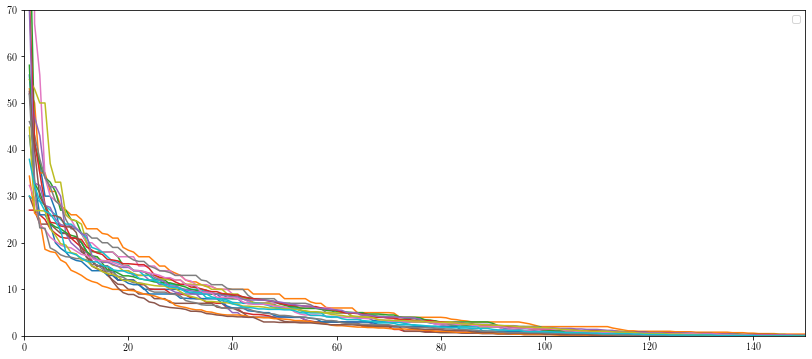

In [7]:
plt.figure(figsize=(14,6))
for yr in df['Year'].unique():
    plt.plot(np.arange(1,354),df[(df['Year']==yr)].sort_values(by='Precipitation',ascending=False)['Precipitation'])
plt.xlim([0,150])
plt.legend()
plt.ylim([0,70])
plt.show()

### Yearly number of dry days

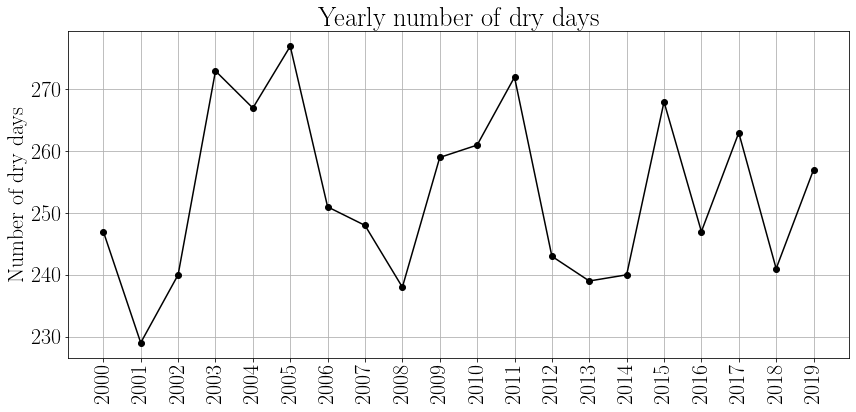

In [21]:
DaysNoRain = pd.Series()
for yr in df['Year'].unique():
    DaysNoRain = DaysNoRain.append(pd.Series({yr : len(df[(df['Year']==yr) & (df['Precipitation']<1)])}),ignore_index=False)

plt.figure(figsize=(14,6))
plt.plot(DaysNoRain,'-ko')
plt.ylabel('Number of dry days')
plt.grid('True')
plt.xticks(np.arange(2000, 2020, 1),rotation='vertical')
plt.title('Yearly number of dry days')
plt.show()

### Identification of dry periods and their duration (number of consecutive dry days)

In [16]:
dryPeriod = np.array([])
cnt = 0
dfDry = pd.DataFrame()
for yr in df['Year'].unique():
    a = df[df['Year']==yr]['Precipitation']
    for d in np.arange(0,len(a)):
        if a.iloc[d]<0.1001:
            cnt += 1
        if (a.iloc[d]>0.1001) & (cnt>0):
            dryPeriod = np.append(dryPeriod,cnt)
            dfDry = dfDry.append(pd.DataFrame([{'Year' : yr,'Dry Days' : cnt, 
                                               }],index=[1]))
            cnt = 0
dfDry = dfDry.reset_index().drop(columns='index')
dfDry

,Year,Dry Days
0,2000.0,8
1,2000.0,11
2,2000.0,5
3,2000.0,1
4,2000.0,4
...,...,...
1113,2019.0,4
1114,2019.0,6
1115,2019.0,1
1116,2019.0,5


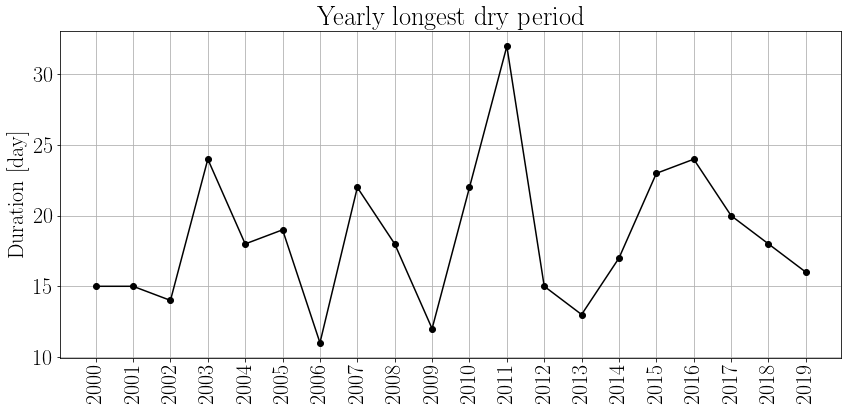

In [29]:
#Yearly longest dry period
plt.figure(figsize=(14,6))
plt.plot(dfDry.groupby('Year').max(),'ko-')
plt.grid('True')
plt.xticks(np.arange(2000,2020,1),rotation='vertical')
plt.ylabel('Duration [day]')
plt.title('Yearly longest dry period')
plt.show()

### Representing all dry periods per year 

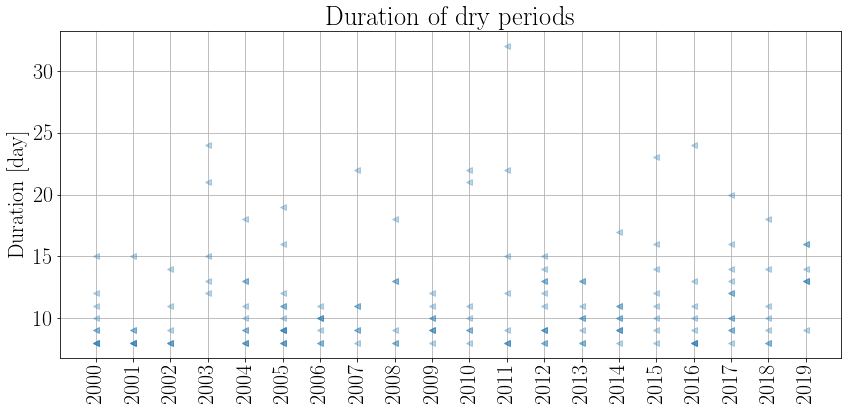

In [28]:
plt.figure(figsize=(14,6))
plt.plot(dfDry[dfDry['Dry Days']>7]['Year'],dfDry[dfDry['Dry Days']>7]['Dry Days'],'<',alpha=0.3)
plt.grid('True')
plt.xticks(np.arange(2000, 2020, 1),rotation='vertical')
plt.ylabel('Duration [day]')
plt.title('Duration of dry periods')
plt.show()
